<a href="https://colab.research.google.com/github/iamksseo/colab/blob/master/AI504_08_Word2Vec_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Week 9: Word2Vec**

## Table of contetns
### **1. word2vec (Skip-gram)**
1-1.Tokenizer <br>
1-2. Build Vocabulary <br>
1-3. Skip-Gram <br>
1-4. Skip-Gram w/ Negative Sampling <br>

### **2. Sentencepiece**
2-1. SentencePiece <br>
2-2. Word2Vec and Visualization

### **3.  HOMEWORK**
3-1. MosesTokenizer & BPE <br><br>

If you have any questions, feel free to ask

*   E-Mail Address : sjpark9503@gmail.com


# **1. Word2Vec**


### i) Import python libraries

In [ ]:
from abc import ABC
from typing import List, Dict, Tuple, Set
import random
import torch.nn.functional as F
from typing import List, Dict, Tuple
from random import randint
import re
import math
from collections import Counter
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from itertools import chain

## **1-1. Implement tokenizer**

### i) Whitespace tokenizer


In this section, you will implement a simplest tokenizer.

Two functionality of tokenizer:
+ Break sentence into words whenever it encounters a whitspace character. Return the list of words.
+ 4 punctuation marks should be an independent token (e.g. "Hi." &#8594; ["Hi", "."])

In [ ]:
def tokenize(sentence):

    ###################################################
    # TODO: Separate a sentence into tokens . , ! ?   #
    sentence = re.sub("[.]", " . ", sentence)
    sentence = re.sub("[,]", " , ", sentence)
    sentence = re.sub("[!]", " ! ", sentence)
    sentence = re.sub("[?]", " ? ", sentence)
    tokens = sentence.split()
    ###################################################
    if not isinstance(tokens, list):
      raise TypeError("Invalid type for tokens.")
    return tokens

### ii) Test tokenizer

In [ ]:
def test_tokenize(sentence, hypothesis):
  tokens = tokenize(sentence)
  print("Tokenizer ouput : ", tokens)
  assert tokens == hypothesis, \
    "Something is wrong. Please try to fix tokenizer."
  print("Test passed.")

sentence1 = "This sentence should be tokenized properly."
answer1 = ['This', 'sentence', 'should', 'be', 'tokenized', 'properly', '.']

sentence2 = "Jhon's book is not popular, but he loves his book."
answer2 = ["Jhon's", "book", "is", "not", "popular", ",", "but", "he", "loves", "his", "book", "."]

sentence3 = "  .,! ?,,'-4.  ! "
answer3 = ['.', ',', '!', '?', ',', ',', "'-4", '.', '!']

test_tokenize(sentence1, answer1)
test_tokenize(sentence2, answer2)
test_tokenize(sentence3, answer3)

Tokenizer ouput :  ['This', 'sentence', 'should', 'be', 'tokenized', 'properly', '.']
Test passed.
Tokenizer ouput :  ["Jhon's", 'book', 'is', 'not', 'popular', ',', 'but', 'he', 'loves', 'his', 'book', '.']
Test passed.
Tokenizer ouput :  ['.', ',', '!', '?', ',', ',', "'-4", '.', '!']
Test passed.


## **1-2 Bulid Vocabulary**
### i) Implement build_vocab
In this section, you will build the vocabulary.

+ Tips
  + Please read the arguments section carefully.
  + Rare words can cause over-fitting, so we will replace these words to \<UNK> tokens.
  + Counter in the _collection_ library would be helpful.

In [ ]:
'''
    Arguments:
    sentences -- The list of sentence to build vocab. Each sentence is a list of words.
    min_freq -- The minimum frequency of a word. Words that have a frequency less than a threshold are excluded from a vocabulary.

    Return:
    idx2word -- A dictionary which maps an index to the word , key : index (int), value : word (str)   ex) {0:'<PAD>', 1:'<UNK>', 2:'This', 3:'sentence', ...}
    word2idx -- A dictionary which maps the word to an index, key : word (str), value : index (int)   ex) {'<PAD>': 0, '<UNK>': 1, 'This': 2, 'sentence': 3, ...}
    word_freq -- A dictionary which maps the word to its frequency, key : word (str), value : index (int)
'''

def build_vocab(sentences, min_freq) :
    word2idx = {"<UNK>": 0}
    idx2word = {0: "<UNK>"} 
    
    ############################################################################
    # TODO : Implement build_vocab

    # Count word frequency
    flatten = list(chain(*sentences))
    word_freq = dict(Counter(flatten))
    rare_word_freq = 0 

    # Build vocab
    for word, freq in word_freq.copy().items():
      # Filter the rare words
      if freq >= min_freq:
        # Add word to vocabulary
        if word not in word2idx:
            idx2word[len(word2idx)] = word
            word2idx[word] = len(word2idx)
      # Count rare words
      else:
        word_freq.pop(word)
        rare_word_freq += freq
    # Add <UNK> frequency to word frequency
    word_freq["<UNK>"] = rare_word_freq 
    ############################################################################

    return idx2word, word2idx, word_freq

### ii) Test build_vocab function

In [ ]:
print("*"*30, "Test 1","*"*30)
sentences = [["This", "is", "a", "sentence", "."],
              ["Jhon", "'s", "book", "is", "not", "popular", ",", "but", "he", "loves", "his", "book", "."]]

idx2word, word2idx, word_freq = build_vocab(sentences, min_freq=1)

print("idx2word : ", idx2word)
print("word2idx : ", word2idx)
print("word_freq", word_freq)
print()

print("*"*30, "Test 2","*"*30)
sentences = [["a", "b", "c", "d", "e"],
              ["c", "d", "f", "g"],
              ["d", "e", "g", "h"]]

idx2word, word2idx, word_freq = build_vocab(sentences, min_freq=2)

print("idx2word : ", idx2word)
print("word2idx : ", word2idx)
print("word_freq", word_freq)

****************************** Test 1 ******************************
idx2word :  {0: '<UNK>', 1: 'This', 2: 'is', 3: 'a', 4: 'sentence', 5: '.', 6: 'Jhon', 7: "'s", 8: 'book', 9: 'not', 10: 'popular', 11: ',', 12: 'but', 13: 'he', 14: 'loves', 15: 'his'}
word2idx :  {'<UNK>': 0, 'This': 1, 'is': 2, 'a': 3, 'sentence': 4, '.': 5, 'Jhon': 6, "'s": 7, 'book': 8, 'not': 9, 'popular': 10, ',': 11, 'but': 12, 'he': 13, 'loves': 14, 'his': 15}
word_freq {'This': 1, 'is': 2, 'a': 1, 'sentence': 1, '.': 2, 'Jhon': 1, "'s": 1, 'book': 2, 'not': 1, 'popular': 1, ',': 1, 'but': 1, 'he': 1, 'loves': 1, 'his': 1, '<UNK>': 0}

****************************** Test 2 ******************************
idx2word :  {0: '<UNK>', 1: 'c', 2: 'd', 3: 'e', 4: 'g'}
word2idx :  {'<UNK>': 0, 'c': 1, 'd': 2, 'e': 3, 'g': 4}
word_freq {'c': 2, 'd': 3, 'e': 2, 'g': 2, '<UNK>': 4}


## **1-3 Skip-Gram**
In this section, we will implement Skip-Gram. We also prepare the inputs for training Word2Vec.
### i) Prepare training data.
In this code block, we will implement the function which returns a (center_word, surrounding_words) pair for Skip-Gram.



![picture](https://drive.google.com/uc?id=1z3fcVn_S4HKj8TXf4Recs8ATOxK8yCh5)
*   The window size (3 in this figure) is a hyperparameter.




In [ ]:
""" 
Argument:
  tokens -- A sentence where the center word and the surrounding words come from (List[str])
  win_size -- context window size (int)

Return:
  window_pairs -- List of (center word, surrounding_word) pairs. (List[Tuple])
                  For example, # ["Jhon's", "book", "is", "not", "popular"] w/ win_size 2, -> [("Jhon's", 'book'), ("Jhon's", 'is'), ('book', "Jhon's"), ('book', 'is'), ('book', 'not'), ('is', "Jhon's"), ('is', 'book'), ...]
"""

def get_window_pairs(tokens, win_size=4):
    window_pairs = []
    ################# Implement here. #############
    for idx, token in enumerate(tokens):
        start = max(0, idx - win_size)
        end = min(len(tokens), idx + win_size + 1)
        for win_idx in range(start, end):
            if not idx == win_idx:
                pair = (token, tokens[win_idx])
                window_pairs.append(pair)
    ###############################################
    return window_pairs

### ii) Test input data

In [ ]:
sentence = ["Jhon's", "book", "is", "not", "popular", ","]
window_pairs = get_window_pairs(sentence, win_size=2)

for idx in range(10):
  print("center word : ", window_pairs[idx][0])
  print("surrounding_words : ", window_pairs[idx][1])
  print()

center word :  Jhon's
surrounding_words :  book

center word :  Jhon's
surrounding_words :  is

center word :  book
surrounding_words :  Jhon's

center word :  book
surrounding_words :  is

center word :  book
surrounding_words :  not

center word :  is
surrounding_words :  Jhon's

center word :  is
surrounding_words :  book

center word :  is
surrounding_words :  not

center word :  is
surrounding_words :  popular

center word :  not
surrounding_words :  book



### iii) Prepare dataset
In this section, we will implement the negative sampling function to improve Skip-Gram. 

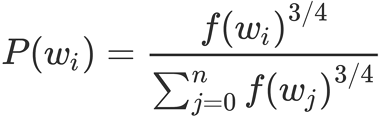

In [ ]:
class SkipgramDataset(Dataset):
    PAD_TOKEN = '<PAD>'
    PAD_TOKEN_IDX = 0
    UNK_TOKEN = '<UNK>'
    UNK_TOKEN_IDX = 1

    def __init__(self, document, window_size, min_freq, negative_sampling=False):
        self._window_size = window_size

        tokens = [tokenize(line.strip().lower()) for line in document]
        idx2word, word2idx, word_freq = build_vocab(tokens, min_freq=min_freq)
        
        self._idx2word = idx2word
        self._word2idx = word2idx
        self._word_freq = word_freq
        
        if negative_sampling:
          self.negative_sample_table = list()
          self.prepare_negative_samples(power = 0.75)

        self.prepare_data(tokens, negative_sampling)
        
    @property
    def n_tokens(self):
        return len(self._idx2word)
    
    def prepare_negative_samples(self, power):
        """ 
        Arguments:
        power -- (int)
        word_freq -- A dictionary which maps the word to its frequency, key : word (str), value : index (int)

        Return:
        self.negative_sample_table -- 1D numpy array which is filled with the vocabulary index. We desire that the random sampling from this array is equivalent to sample the index from the distribution above.
        """
        ############################ TODO : implement the negative sampler##################################
        vocab_size = len(self._word_freq)
        power = 0.75
        norm = sum([math.pow(count, power) for count in self._word_freq.values()]) # Normalizing constant

        table_size = int(1e6) # Length of the unigram table
        table = np.zeros(table_size, dtype=np.int32)

        p = 0 # Cumulative probability
        i = 0
        for word, count in self._word_freq.items():
            p += float(math.pow(count, power))/norm
            while i < table_size and float(i) / table_size < p:
                table[i] = self.word2idx(word)
                i += 1
        self.negative_sample_table = table
        ######################################################################################################

    def negative_sampler(self, K=5):
        indices = np.random.randint(low=0, high=len(self.negative_sample_table), size=K)
        return [self.negative_sample_table[i] for i in indices]

    def prepare_data(self, tokens, negative_sampling=False):
      self.features = list()
      for tokenized_sentence in tokens:
          feature = [(self.word2idx(x),self.word2idx(y)) for x,y in get_window_pairs(tokenized_sentence, self._window_size)]
          if negative_sampling:
            feature = list()
            for center, surrounding in get_window_pairs(tokenized_sentence, self._window_size):
              negative_sample = self.negative_sampler(K=5)
              feature.append((self.word2idx(center), [self.word2idx(surrounding),]+ negative_sample))
          self.features.append(feature)
      self.features = list(chain(*self.features))

    def idx2word(self, index: int) -> str:
        return self._idx2word[index]

    def word2idx(self, word: str) -> int:
        if word in self._word2idx:
            return self._word2idx[word]
        else:
            return self._word2idx["<UNK>"]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        return self.features[i]

In [ ]:
document = [
            "Word2vec is a technique for natural language processing published in 2013.",
            "The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text.",
            "Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence."
            ]

In [ ]:
db = SkipgramDataset(document, window_size=3, min_freq=1)

### iv) Skip-Gram without negative sampling
In this section, you will implement the obejctive function of Skip-Gram.

The objective function is the softmax over a center word and surrounding words.

![picture](https://drive.google.com/uc?id=1Krmu4OoPEwnkhaBSsShEMDzEWuMZvVxy)

In [ ]:
class Word2Vec(torch.nn.Module, ABC):
    def __init__(self, n_tokens, embedding_dimension):
        super().__init__()

        self.input_embedding = torch.nn.Parameter(torch.empty([n_tokens, embedding_dimension]), requires_grad=True)
        self.output_embedding = torch.nn.Parameter(torch.empty([n_tokens, embedding_dimension]), requires_grad=True)

        self.init_weights()

    def init_weights(self):
        torch.nn.init.normal_(self.input_embedding.data)
        torch.nn.init.normal_(self.output_embedding.data)
    
    def forward(self, input_feature):
        """ 
        Arguments:
        input_embedding -- Embedding matrix for the input, the center word in our case.
        output_embedding -- Embedding matrix for the ouput, the surrounding words in our case.
        input_feautres -- Tuple; 
                          (
                            center word indeces, shape: [batch_size]
                            surrounding word indeces, shape: [batch_size]
                          ) 

        Return:
        loss
        """
        ############################################################################
        ## TODO : Define loss function
        input_idx, target_idx = input_feature
        input_embed = self.input_embedding[input_idx]
        logit = torch.einsum('ik,jk->ij',[input_embed, self.output_embedding])
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logit, target_idx)
        ############################################################################
        return loss

### v) Test softmax loss


In [ ]:
# Prepare data
db = SkipgramDataset(document, window_size=3, min_freq=1)
data_loader = DataLoader(db, batch_size=4)
# Prepare model & optimizer
model = Word2Vec(n_tokens=len(db._idx2word),embedding_dimension=64)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

for epoch in range(10):
  epoch_loss = 0
  for batch in data_loader:
    optimizer.zero_grad()
    # forward
    loss = model(batch)
    epoch_loss += loss.item()
    # backward
    loss.backward()
    optimizer.step()
  print(f"epoch: {epoch}, loss: {epoch_loss}")

epoch: 0, loss: 1124.036211490631
epoch: 1, loss: 1111.8959074020386
epoch: 2, loss: 1100.1118307113647
epoch: 3, loss: 1088.64253282547
epoch: 4, loss: 1077.4600100517273
epoch: 5, loss: 1066.5463843345642
epoch: 6, loss: 1055.890989780426
epoch: 7, loss: 1045.4878330230713
epoch: 8, loss: 1035.333519935608
epoch: 9, loss: 1025.4256596565247


## **1-4 Skip-Gram with Negative Sampling**

In this section, you will implement the obejctive function of Skip-Gram.

The objective function is the softmax over the positive sample and negative samples.

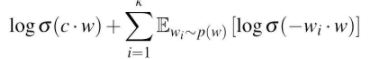



In [ ]:
class NCEWord2Vec(torch.nn.Module, ABC):
    def __init__(self, n_tokens, embedding_dimension):
        super().__init__()

        self.input_embedding = nn.Embedding(n_tokens, embedding_dimension)
        self.output_embedding = nn.Embedding(n_tokens, embedding_dimension)

        self.init_weights()

    def init_weights(self):
        torch.nn.init.normal_(self.input_embedding.weight.data)
        torch.nn.init.normal_(self.output_embedding.weight.data)
    
    def forward(self, input_feature):
        """ 
        Arguments:
        input_embedding -- Embedding matrix for the input, the center word in our case.
        output_embedding -- Embedding matrix for the ouput, the surrounding words in our case.
        input_feautres -- Tuple; 
                          (
                            center word indeces, shape: [batch_size]
                            surrounding word & negative sample indeces, shape: [batch_size, K]
                          ) 

        Return:
        loss
        """
        ############################################################################
        ## TODO : Define loss function
        input_idx, negative_sample_idx = input_feature
        input_embed = self.input_embedding(input_idx)
        logit = torch.einsum('ik,ijk->ij',[input_embed, self.output_embedding(negative_sample_idx)])
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logit, torch.tensor([0]*input_idx.size(0)))
        ############################################################################
        return loss

### ii) Test Skip-Gram w/ Negative Sampling.

In [ ]:
# Prepare data
db = SkipgramDataset(document, window_size=3, min_freq=1, negative_sampling=True)
data_loader = DataLoader(db, batch_size=4)
# Prepare model & optimizer
model = NCEWord2Vec(n_tokens=len(db._idx2word),embedding_dimension=64)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

for epoch in range(10):
  epoch_loss = 0
  for batch in data_loader:
    # batchfy negative samples
    batch[-1] = torch.stack(batch[-1]).transpose(0,1)
    optimizer.zero_grad()
    # forward
    loss = model(batch)
    epoch_loss += loss.item()
    # backward
    loss.backward()
    optimizer.step()
  print(f"epoch: {epoch}, loss: {epoch_loss}")

epoch: 0, loss: 716.7459259033203
epoch: 1, loss: 712.3140096664429
epoch: 2, loss: 707.9008028507233
epoch: 3, loss: 703.5062708854675
epoch: 4, loss: 699.130481004715
epoch: 5, loss: 694.773473739624
epoch: 6, loss: 690.4353003501892
epoch: 7, loss: 686.1159868240356
epoch: 8, loss: 681.8156373500824
epoch: 9, loss: 677.5343039035797


## **2. SentencePiece and Word2Vec**

### **1) Setup**

In [ ]:
!pip install sentencepiece
import nltk
nltk.download('movie_reviews')
!wget https://www.dropbox.com/s/8w9n3cim0b32k2y/train.txt
!wget https://www.dropbox.com/s/pwhn9gyjgvg39v5/pos_train.txt
!wget https://www.dropbox.com/s/7h8aa1xe270fnfy/neg_train.txt

     |████████████████████████████████| 1.2 MB 5.4 MB/s 
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
--2021-10-27 09:33:26--  https://www.dropbox.com/s/8w9n3cim0b32k2y/train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8w9n3cim0b32k2y/train.txt [following]
--2021-10-27 09:33:27--  https://www.dropbox.com/s/raw/8w9n3cim0b32k2y/train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc639c79989b2a50aa0e5cbc10dc.dl.dropboxusercontent.com/cd/0/inline/BY0NlwRkBh8mcvg3Wt81bFexG0STv0vVuczlszLK7BLio_35RGb0pVNCmmzCXrRnaFhfWq-bg8_aonDnnenUA06Mxc7rl2ukCv8q5_Kig1sBvf2ekN9n3j2a9BfS0XlSmoKRnYkqUZVZ-0MTvlBIPvPC/file# [following]
--2021-10-27 09:33:28

### **2) Import required packages**

In [ ]:
import os
import random
import numpy as np
from gensim.models import word2vec #  word2vec library  
import nltk
from nltk.corpus import movie_reviews # For Corpus 
from sklearn.manifold import TSNE # For TSNE
from sklearn.metrics import accuracy_score # for calculating accuracy score 
import matplotlib as mpl
import matplotlib.pyplot as plt
import sentencepiece as spm # For sentencepiece model

### **3) Set Parameter**

In [ ]:
# Parameters for learning skip-gram and cbow model
num_features = 300 # Embedding Vector Size
negative = 10 # words for negative sampling
min_word_count = 10 # minimum words in one sentence
window = 5 # context window size
downsampling = 0.75 # Lower frequency for high-frequency words 
epoch = 5

### **4) Prepare data & Use SentencePiece**

In [ ]:
# preparing data
sentences_for_SP = []
sentences_naive = []
pos_data = open("./pos_train.txt").readlines()
neg_data = open("./neg_train.txt").readlines()
data_ = pos_data + neg_data

In [ ]:
for line in data_:
    sentences_naive.append(line.strip().split(' '))

In [ ]:
%%time

spm.SentencePieceTrainer.train(input="./train.txt", model_prefix='m', vocab_size=10000, user_defined_symbols=['[CLS]', '[SEP]'])
sp = spm.SentencePieceProcessor(model_file='./m.model')

for line in data_:
  sentences_for_SP.append(sp.encode(line, out_type=str))

CPU times: user 13.3 s, sys: 227 ms, total: 13.5 s
Wall time: 10.3 s


### **5) Training**

In [ ]:
%%time

# skip-gram model training with naive splitted data
naive_model = word2vec.Word2Vec(sentences_naive,
                                sg = 1, # CBOW = 0, skip-gram = 1
                                negative=negative,
                                size=num_features, 
                                min_count=min_word_count,
                                window=window,
                                sample=downsampling,
                                iter=epoch)

# skip-gram model training with sentencepiece data
model_with_SP = word2vec.Word2Vec(sentences_for_SP,
                                  sg = 1, # CBOW = 0, skip-gram = 1
                                  negative=negative,
                                  size=num_features, 
                                  min_count=min_word_count,
                                  window=window,
                                  sample=downsampling,
                                  iter=epoch)

CPU times: user 7min 13s, sys: 990 ms, total: 7min 14s
Wall time: 3min 44s


### **6) Training Result**

In [ ]:
naive_model.wv.most_similar("man") # most similar  word with 'man' in naive skip-gram

[('boy', 0.7536931037902832),
 ('woman', 0.7319361567497253),
 ('person', 0.7007241249084473),
 ('doctor', 0.6976638436317444),
 ('guy', 0.6761626601219177),
 ('teenager', 0.6758589744567871),
 ('lady', 0.6725515723228455),
 ('kid', 0.6635710000991821),
 ('girl', 0.661820650100708),
 ('bird', 0.6439629197120667)]

In [ ]:
naive_model.wv.vocab

{'films': <gensim.models.keyedvectors.Vocab at 0x7f11c74e2890>,
 'adapted': <gensim.models.keyedvectors.Vocab at 0x7f11c15650d0>,
 'from': <gensim.models.keyedvectors.Vocab at 0x7f11c1565150>,
 'comic': <gensim.models.keyedvectors.Vocab at 0x7f11c1565090>,
 'books': <gensim.models.keyedvectors.Vocab at 0x7f11ce86ae50>,
 'have': <gensim.models.keyedvectors.Vocab at 0x7f11ce86af50>,
 'had': <gensim.models.keyedvectors.Vocab at 0x7f11ce86afd0>,
 'plenty': <gensim.models.keyedvectors.Vocab at 0x7f11ce86ae10>,
 'of': <gensim.models.keyedvectors.Vocab at 0x7f11ce86a510>,
 'success': <gensim.models.keyedvectors.Vocab at 0x7f11ce86ae90>,
 ',': <gensim.models.keyedvectors.Vocab at 0x7f11ce86a5d0>,
 'whether': <gensim.models.keyedvectors.Vocab at 0x7f11ce86af10>,
 "they're": <gensim.models.keyedvectors.Vocab at 0x7f11bcdd05d0>,
 'about': <gensim.models.keyedvectors.Vocab at 0x7f11bcdd0550>,
 'superheroes': <gensim.models.keyedvectors.Vocab at 0x7f11bcdd0610>,
 '(': <gensim.models.keyedvectors.Vo

In [ ]:
vector = naive_model["king"] - naive_model["man"] + naive_model["queen"]

print(naive_model.wv.similar_by_vector(vector, topn=10, restrict_vocab=None))

[('king', 0.725056529045105), ('queen', 0.639255166053772), ('terry', 0.5926758050918579), ('creator', 0.5866645574569702), ('nichols', 0.57554030418396), ('parker', 0.5749438405036926), ('nathan', 0.5737477540969849), ('oz', 0.5729621052742004), ('luke', 0.57085120677948), ('ed', 0.5679799318313599)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


![picture](https://drive.google.com/uc?id=1AF-ADZSgqG8NcsO8LgfmF9JXL6F_uQoP)

In [ ]:
print(naive_model.wv.similarity(w1 = 'man', w2 = 'woman'))
print(naive_model.wv.similarity(w1 = 'uncle', w2 = 'aunt'))
print(naive_model.wv.similarity(w1 = 'king', w2 = 'queen'))

0.73193616
0.7905747
0.61878633


### **7) Visualization**

In [ ]:
def render_TSNE(vocab, word_emb):
    """
    args:
        vocab    - vocab list
        word_emb - word embeddings
    """
    tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32) # initialization
    _tsne = tsne.fit_transform(word_emb) 
    x_coordinate = _tsne[:,0] # x 
    y_coordinate = _tsne[:,1] # y

    # scatter plot initialization
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 20)
    ax.scatter(x_coordinate, y_coordinate)

    for i, word in enumerate(random_vocab):
        ax.annotate(word,(x_coordinate[i], y_coordinate[i]), fontsize=30) # word labeling for each scatters

    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


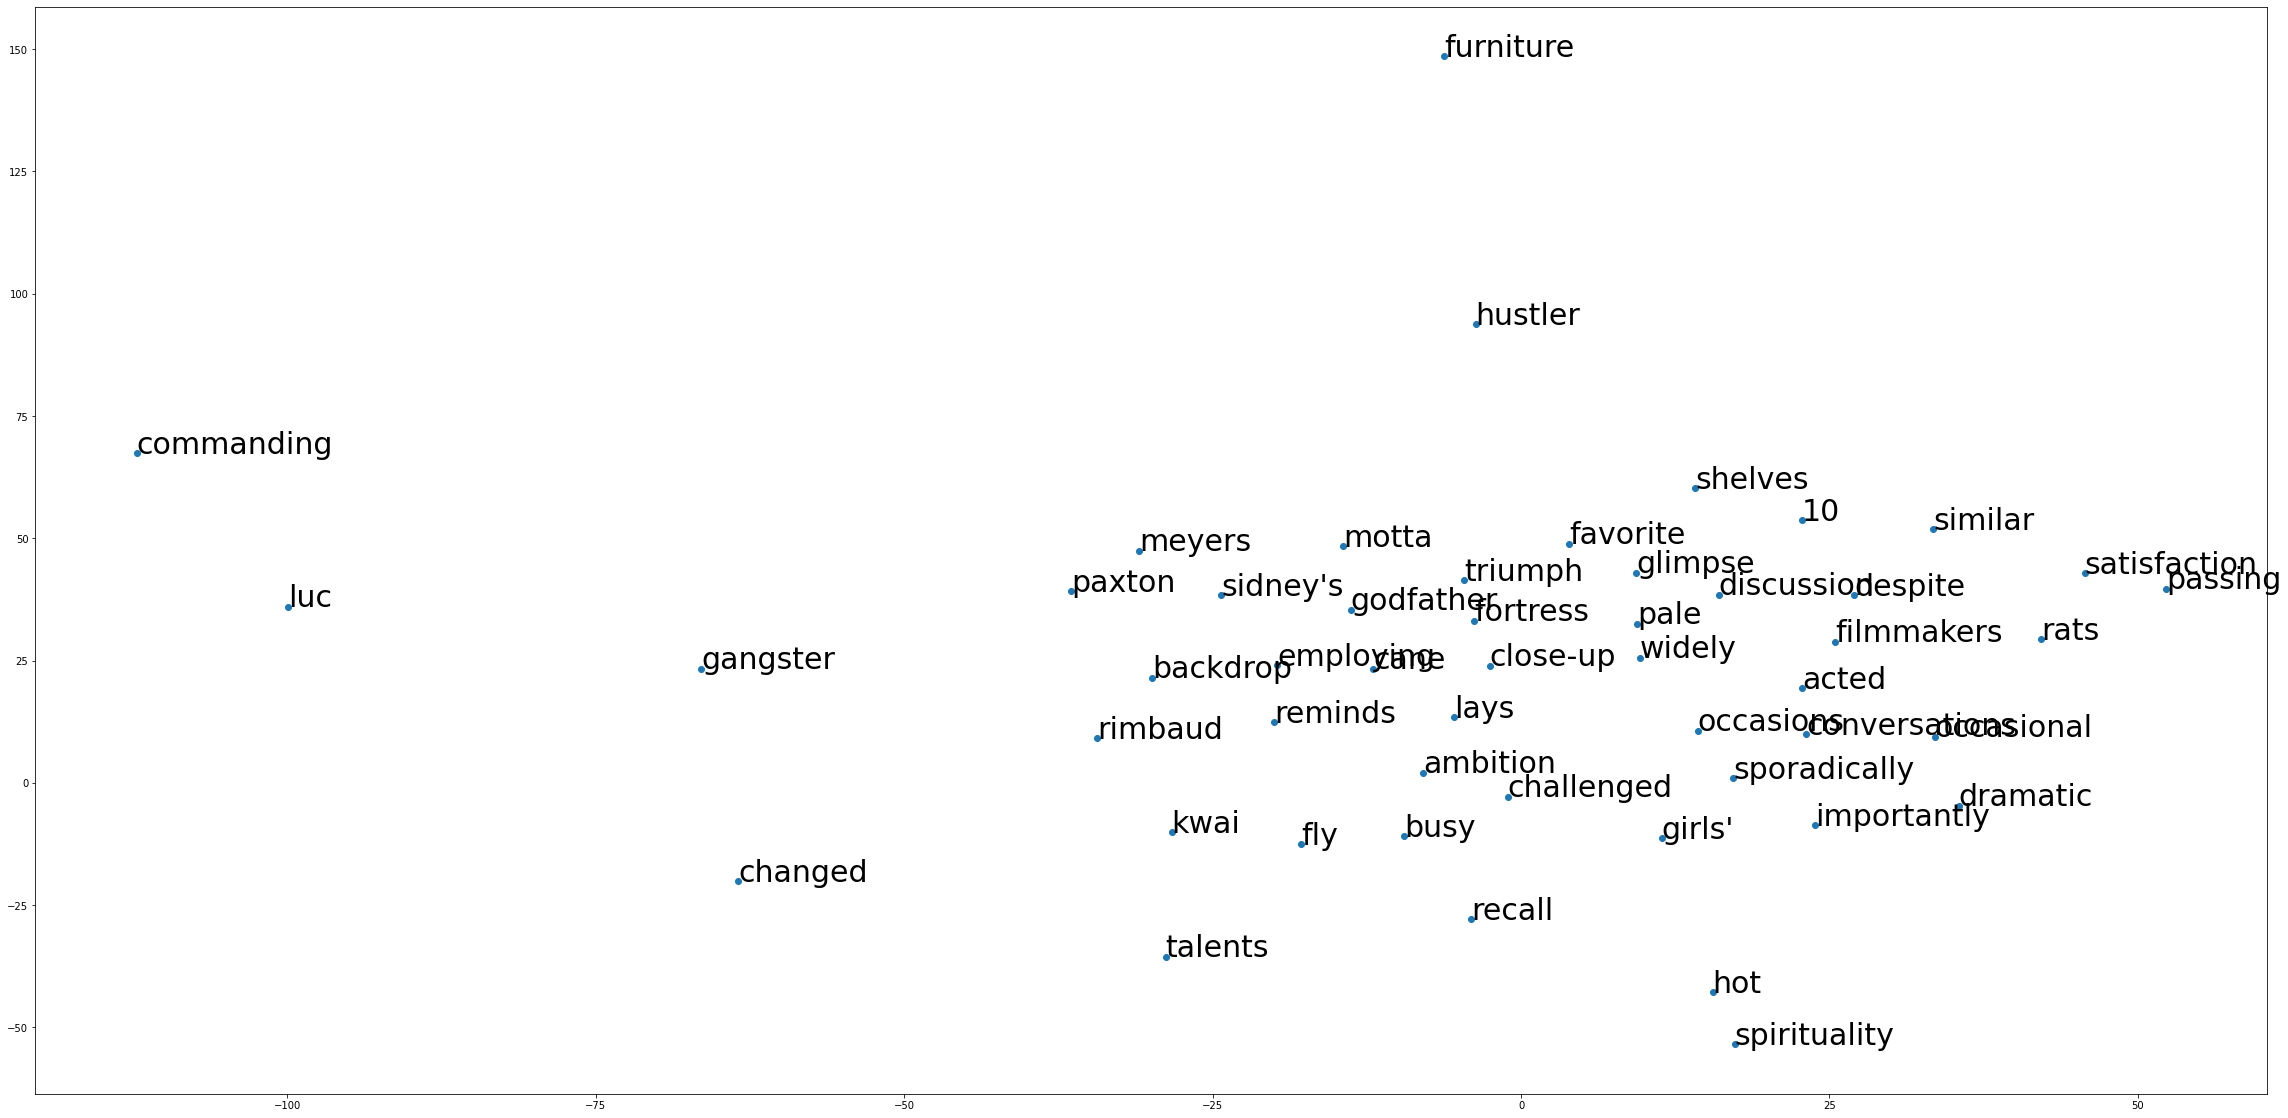

In [ ]:
vocab = list(naive_model.wv.vocab) # Load vocab list
random_vocab = random.sample(vocab,k=50) # Random sampling of 50 words
word_emb = naive_model[random_vocab] # Load embedding vector about sampled words
render_TSNE(random_vocab, word_emb)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


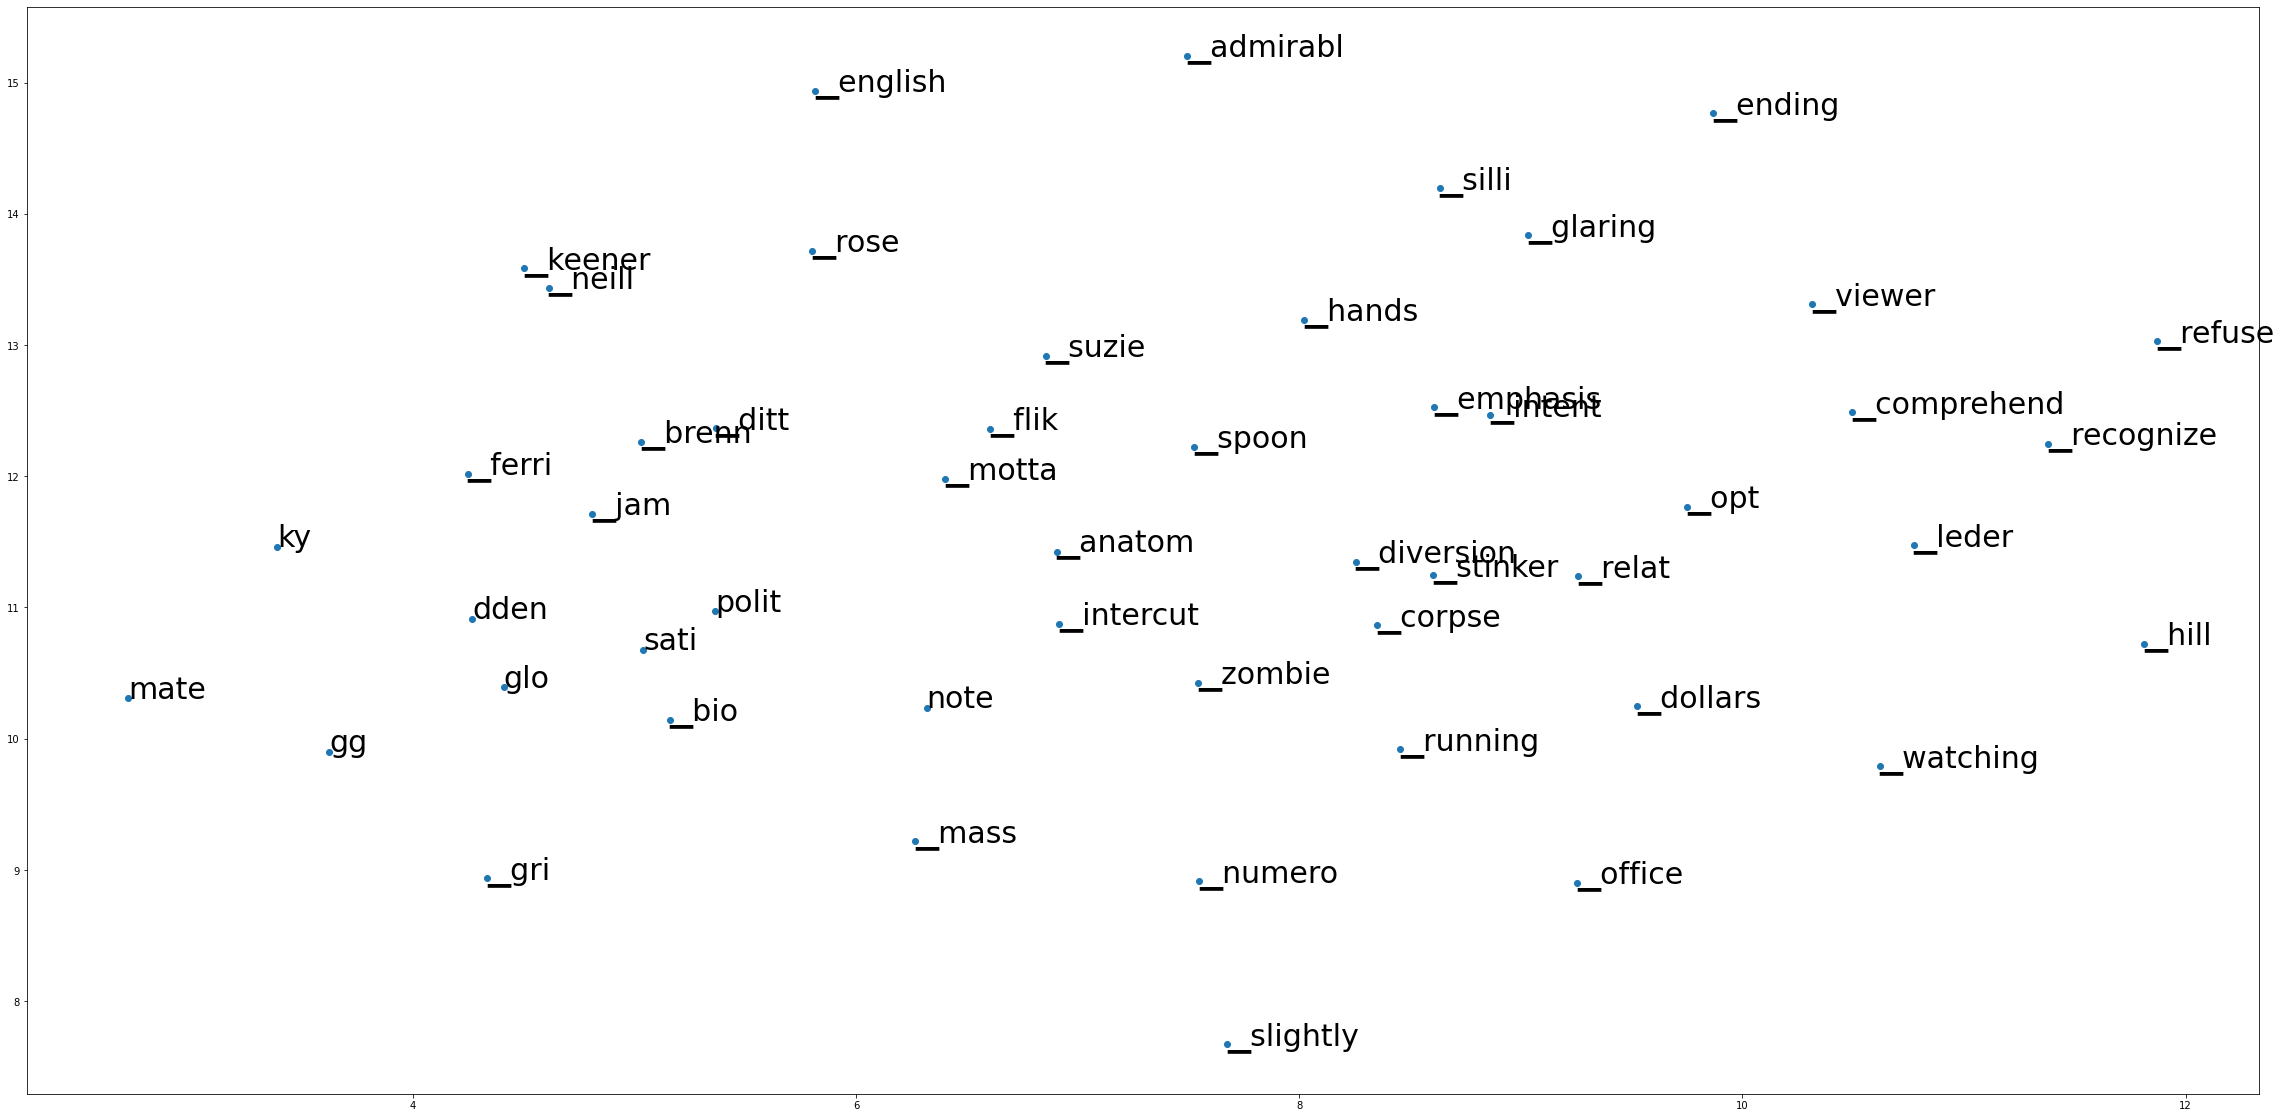

In [ ]:
vocab = list(model_with_SP.wv.vocab) # Load vocab list
random_vocab = random.sample(vocab,k=50) # Random sampling of 50 words
word_emb = model_with_SP[random_vocab] # Load embedding vector about sampled words
render_TSNE(random_vocab, word_emb)